# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)
* [Save Modell](#savemodell)
* [Test Modell](#testmodell)
    * [Die Ganauigkeit](#ganauigkeit)
    * [Die Metriken](#metriken)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

In [ ]:
from keras.backend import clear_session
clear_session()
%reload_ext tensorboard

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [1]:
import torch
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from torchvision import models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from functools import partial
import keras
import itertools
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [2]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} 

In [ ]:
# Audiodateien
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive')
gdrive_path = os.getcwd()

In [29]:
path_model = Path.cwd() / "ravdess" / "modell" / "path_model.h5"
PATH_TO_RAVDESS = Path.cwd()/"ravdess"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS/"train"
bs_train = 1440

In [9]:
# Confusion Matrix
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [10]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [11]:
def loader(path):
    ravdess = PrecomputedRavdess(path,
                                  img_transforms=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
    )
    return ravdess

In [12]:
ravdess_train = loader(PATH_RAVDESS_TRAIN)
ravdess_train_loader = torch.utils.data.DataLoader(ravdess_train,bs_train, shuffle=True)
spectogram = torch.utils.data.DataLoader(ravdess_train,64,shuffle=True )

### Die Datenvisualisierung<a class="anchor" id="#datenvisual"></a>

Validationslabel: tensor([2, 5, 1, 7, 4, 1, 7, 3, 2, 3, 3, 2, 3, 4, 7, 6, 3, 4, 0, 6, 2, 6, 5, 3,
        2, 2, 1, 7, 6, 4, 5, 5, 4, 3, 5, 7, 3, 0, 5, 4, 4, 0, 5, 5, 5, 6, 5, 2,
        0, 2, 4, 2, 7, 2, 6, 3, 7, 7, 5, 6, 5, 6, 6, 0])


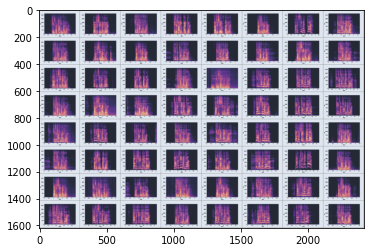

In [13]:
images, labels = next(iter(ravdess_train_loader))  
img, label = next(iter(spectogram))  
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
print('Validationslabel:',label)
imshow(torchvision.utils.make_grid(img)/3)

In [14]:
labels.shape

torch.Size([1161])

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [15]:
batch_size = 64
img_width, img_height, img_num_channels = 3,200,300
loss_function = sparse_categorical_crossentropy
no_classes = 8
optimizer = Adam()
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [16]:
# Residual Unit-Schicht
# Im Konstruktor werden alle erforderlichen Schichten erzeugt
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [17]:
#Das ResNet-34 kann mit einem Sequential-Modell angebaut werden.
def build_model():
    model = keras.models.Sequential()
    model.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 8
    for filters in [64] * 1 + [128] * 1 + [256] * 1: 
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(no_classes, activation="softmax"))
    optimizer = keras.optimizers.Nadam(lr=1e-3)
    model.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])
    return model

In [18]:
# Datentyp-Umwandelung
images = (tf.cast(images, tf.float32) / 255).numpy()
labels = labels.numpy()

### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 200, 64)        172800    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 200, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 3, 200, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 100, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1, 50, 64)         78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 1, 25, 128)        230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 1, 13, 256)        9

### Modell-Training<a class="anchor" id="#modelltraining"></a>

In [20]:
history = model.fit(images, labels,
            batch_size=batch_size,
            epochs=100,        
            verbose=verbosity,
            validation_split = 0.2) 

Epoch 1/100
15/15 [==============================] - 18s 1s/step - loss: 2.0215 - accuracy: 0.2038 - val_loss: 2.0724 - val_accuracy: 0.1760
Epoch 2/100
15/15 [==============================] - 15s 978ms/step - loss: 1.6805 - accuracy: 0.3684 - val_loss: 2.0610 - val_accuracy: 0.1760
Epoch 3/100
15/15 [==============================] - 15s 975ms/step - loss: 1.3560 - accuracy: 0.4877 - val_loss: 2.0553 - val_accuracy: 0.1760
Epoch 4/100
15/15 [==============================] - 15s 976ms/step - loss: 1.1744 - accuracy: 0.5821 - val_loss: 2.0654 - val_accuracy: 0.1760
Epoch 5/100
15/15 [==============================] - 15s 979ms/step - loss: 1.0587 - accuracy: 0.6058 - val_loss: 2.1096 - val_accuracy: 0.1760
Epoch 6/100
15/15 [==============================] - 15s 980ms/step - loss: 0.6944 - accuracy: 0.7811 - val_loss: 2.1480 - val_accuracy: 0.1760
Epoch 7/100
15/15 [==============================] - 15s 974ms/step - loss: 0.6012 - accuracy: 0.8171 - val_loss: 2.3532 - val_accuracy: 0.

#### Die Genauigkeit

In [21]:
loss, acc = model.evaluate(images, labels)
print("Train, accuracy: {:5.2f}%".format(100*acc))

37/37 [==============================] - 4s 110ms/step - loss: 0.2851 - accuracy: 0.9311
Train, accuracy: 93.11%


#### Die Metriken

19/19 [==============================] - 4s 204ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       154
           1       0.95      0.96      0.96        80
           2       0.93      0.96      0.95       149
           3       0.89      0.95      0.92       157
           4       0.94      0.85      0.89       154
           5       0.93      0.99      0.96       158
           6       0.90      0.91      0.90       154
           7       0.95      0.92      0.93       155

    accuracy                           0.93      1161
   macro avg       0.93      0.93      0.93      1161
weighted avg       0.93      0.93      0.93      1161

Confusion matrix, without normalization


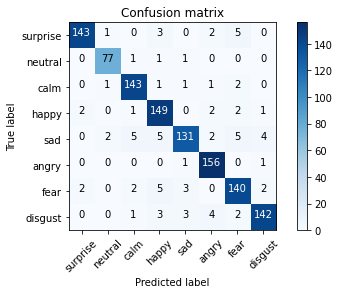

In [22]:
y_pred_train = model.predict(images, batch_size=64, verbose=1)
y_pred_b = np.argmax(y_pred_train, axis=1)

print(classification_report(labels, y_pred_b))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(labels, y_pred_b), classes=class_names)
plt.show()

#### Visualisierung

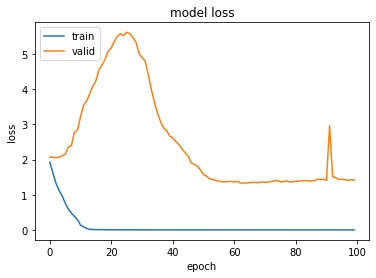

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

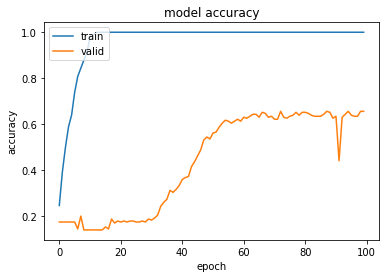

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

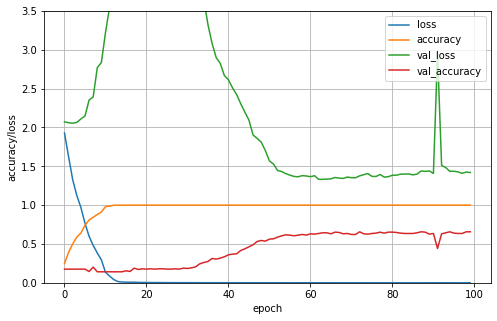

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.gca().set_ylim(0, 3.5)
plt.show()

## Save Modell<a class="anchor" id="#savemodell"></a>

In [31]:
model.save_weights(path_model)

## Test Modell<a class="anchor" id="#testmodell"></a>

In [32]:
PATH_RAVDESS_TEST = PATH_TO_RAVDESS/"test"
bs_test = 1440

In [33]:
ravdess_test = loader(PATH_RAVDESS_TEST)
ravdess_test_loader = torch.utils.data.DataLoader(ravdess_test,bs_test, shuffle=True)
images_test, labels_test = next(iter(ravdess_test_loader))  

In [34]:
labels_test.shape

torch.Size([279])

In [35]:
images_test = (tf.cast(images_test, tf.float32) / 255).numpy()
labels_test = labels_test.numpy()

In [36]:
model_test = build_model()
model_test.load_weights(path_model)

### Die Ganauigkeit<a class="anchor" id="#ganauigkeit"></a>

In [37]:
loss, acc = model_test.evaluate(images_test, labels_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

9/9 [==============================] - 1s 108ms/step - loss: 1.4732 - accuracy: 0.5942
Restored model, accuracy: 64.52%


### Die Metriken<a class="anchor" id="#metriken"></a>

5/5 [==============================] - 1s 183ms/step
              precision    recall  f1-score   support

           0       0.78      0.47      0.59        38
           1       0.59      0.62      0.61        16
           2       0.84      0.88      0.86        43
           3       0.46      0.66      0.54        35
           4       0.61      0.45      0.52        38
           5       0.59      0.65      0.62        34
           6       0.62      0.63      0.62        38
           7       0.70      0.76      0.73        37

    accuracy                           0.65       279
   macro avg       0.65      0.64      0.64       279
weighted avg       0.66      0.65      0.64       279

Confusion matrix, without normalization


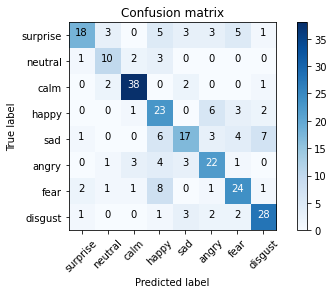

In [38]:
y_pred = model_test.predict(images_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(labels_test, y_pred_bool))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(labels_test, y_pred_bool), classes=class_names)
plt.show()

In [39]:
model_test.save_weights(path_model)